In [1]:
# imports 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from time import time

import joblib

# Two Classifiers without Reduction

In [2]:
# load dataset

X = np.load('ships_dataset/ship_data.npy')
t = np.load('ships_dataset/ship_labels.npy')

label_names = ['no_ship', 'ship']

X.shape, t.shape

((4000, 80, 80, 3), (4000,))

I have decided to retain the RGB values by having each of the 3 channels as one entry in the image, meaning the new shape of the image should be 80x240. This will allow for the models to also train on the color data, as opposed to utilizing grayscale which may lose some of the information from the RGB features. I will also further reshape this into a 1-D array so that the model is able to utilize the data effectively.

In [3]:
# reshape to account for RGB

X = X.reshape((X.shape[0], -1))

X.shape

(4000, 19200)

In [4]:
# split data into training and testing

X_train, X_test, t_train, t_test = train_test_split(
                                        X, t,
                                        test_size=0.2,
                                        random_state=0,
                                        stratify=t)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((3200, 19200), (800, 19200), (3200,), (800,))

Given that there is more representation of the 'no_ship' class than the 'ship' class within the dataset, it was decided to stratify on the target value to ensure that both training and test sets are representative of the entire sample. Additionally, the split was chosen to be an 80/20 split, as this gives a good amount of images to train on, while still leaving enough data in the test set to be representative of the entire population.

I have decided to use a soft-margin SVM with a radial basis function kernel and a random forest classifier as the two classifiers for this project. The choice of the soft-margin SVM with a radial basis function kernel was made due to its ability to find non-linear classifier surfaces, which for image classification is likely to occur. Additionally, with the given size of the data, an SVM should be relatively efficient enough to handle training and cross-validation in a timely manner. With proper hyperparameter tuning, the overfitting of an SVM should be avoided, and combined with the soft-margin, it should be generalizeable to the desired decision surface. The random forest classifier was chosen for similar reasons; due to the decision trees that create it, it should be able to find non-linear classifier surfaces. Additionally, it may also be less susceptible to overfitting with proper tuning. The ability to run multiple decision trees in parallel also should allow for relatively time efficient model training and cross-validation.

It was also decided to utilize a MinMaxScaler on the pixel data, as this should preserve the initial distribution of pixel data while also ensuring the ranges from the models are reasonable and will not be affected by large feature scales.

In [41]:
# build SVM pipeline

svm_pipe = Pipeline([('scaler', MinMaxScaler()),
                     ('svm', SVC(kernel='rbf'))])

svm_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [42]:
# build Random Forest pipeline

rand_for_pipe = Pipeline([('scaler', MinMaxScaler()),
                          ('rand_for', RandomForestClassifier(random_state=0))])
                           
rand_for_pipe

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rand_for', RandomForestClassifier(random_state=0))])

I decided to use 5 folds, as this should allow for enough data to train on and to validate on in the cross-validation scheme given the size of the training data. This should also allow for enough folds to be able to determine if some performance is biased due to the way the validation sets were formed, allowing for a better hyperparameter tuning from the grid search.

Accuracy was chosen as the scoring metric as this is one of the desired scoring metrics and should also be a good indicator of how well the model is labeling images.

The regularization parameter, C, was chosen to be the only hyperparameter that needed tuning, as this should be the most impactful hyperparameter in relation to the sensitivity of the SVM, and whether it will overfit to ensure all points or a certain number of points are properly classified when drawing its decision boundary.

In [44]:
# cross-validate to find regularization parameter, C, for SVM

param_grid = {
    'svm__C': [0.1, 0.5, 1, 10]
}

grid_search_svm_pipe = GridSearchCV(svm_pipe,
                                    param_grid=param_grid,
                                    cv=KFold(5, shuffle=True, random_state=0),
                                    scoring='accuracy')

grid_search_svm_pipe.fit(X_train, t_train)

print(grid_search_svm_pipe.best_params_)

{'svm__C': 10}


In [48]:
# train final model with desired hyperparameters, and calculate training time

svm_model = Pipeline([('scaler', MinMaxScaler()),
                      ('svm', SVC(kernel='rbf', C=10))])

t0 = time()
svm_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
svm_model

Training Time: 11 sec


Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC(C=10))])

I have decided to hyperparameter tune for n_estimators and max_depth for the Random Forest; these two hyperparameters should be the best judge of the level overfitting from the random forest through max_depth, and should also get an optimum for the amount of trees needed to give generalizeable learning for the random forest. Tuning for more hyperparameters may lead to a large amount of time used for cross-validation.

In [49]:
# cross-validate to find n_estimators and max_depth for Random Forest

param_grid = {
    'rand_for__n_estimators': [50, 100, 200],
    'rand_for__max_depth': [20, 30, 50, 70]
}

grid_search_rand_for_pipe = GridSearchCV(rand_for_pipe,
                                         param_grid=param_grid,
                                         cv=KFold(5, shuffle=True, random_state=0),
                                         scoring='accuracy')

grid_search_rand_for_pipe.fit(X_train, t_train)

print(grid_search_rand_for_pipe.best_params_)

{'rand_for__max_depth': 20, 'rand_for__n_estimators': 200}


In [52]:
# train final model with desired hyperparameters, and calculate training time

rand_for_model = Pipeline([('scaler', MinMaxScaler()),
                           ('rand_for', RandomForestClassifier(random_state=0,
                                                               n_estimators=200,
                                                               max_depth=20))])

t0 = time()
rand_for_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
rand_for_model

Training Time: 41 sec


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rand_for',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=0))])

In [56]:
# save models as pickle files to use in testing

joblib.dump(svm_model, 'models/svm_model.pk1')
joblib.dump(rand_for_model, 'models/rand_for_model.pk1')

pd.DataFrame(X_test).to_csv('test_data/X.csv', index=False)
pd.DataFrame(t_test).to_csv('test_data/t.csv', index=False)

In [28]:
# save training data as csv to better gauge overfitting in comparison to test data

pd.DataFrame(X_train).to_csv('test_data/X_train.csv', index=False)
pd.DataFrame(t_train).to_csv('test_data/t_train.csv', index=False)

#  PCA Reduction

I decided to again utilize MinMaxScaling when using PCA. This should ensure that features do not create large weights for the PCA, and should still preserve the original structure of the data distributions.

In [6]:
# create PCA pipeline to vizualize RMSE as a function of preserved components

pca_pipe = Pipeline([('scaler', MinMaxScaler()),
                     ('pca', PCA())])

pca_pipe.fit(X_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA())])

In [7]:
# find the number of components needed to explain 90% of the variance

num_pcs = np.where(np.cumsum(pca_pipe.named_steps.pca.explained_variance_ratio_)>=0.9)[0][0]

print('Number of Components needed to explain 90% of Variance: ', num_pcs + 1)
print('Exact Variance at ', num_pcs + 1, 
      ' Components: ', np.cumsum(pca_pipe.named_steps.pca.explained_variance_ratio_)[num_pcs])

Number of Components needed to explain 90% of Variance:  102
Exact Variance at  102  Components:  0.9000259993628885


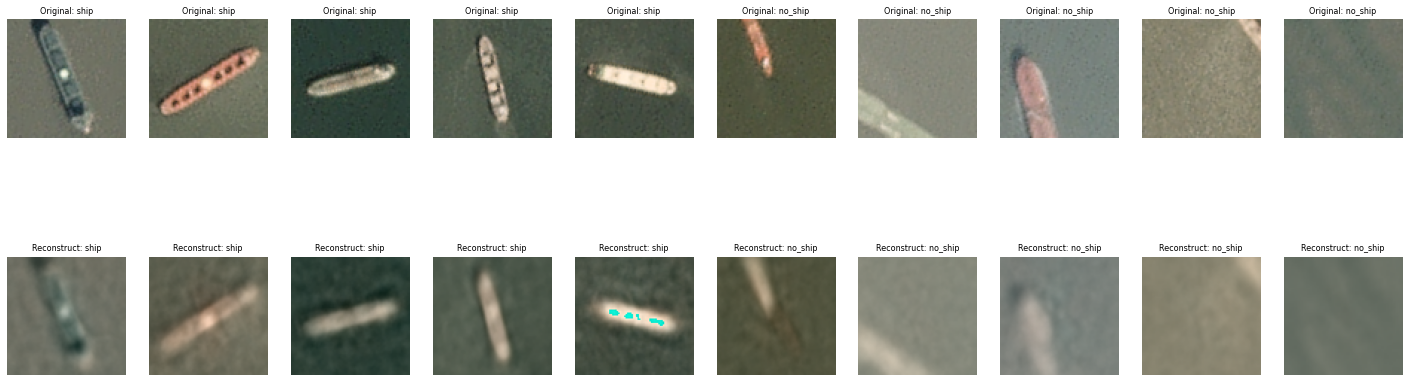

In [8]:
# visualize images at the 90% variance level

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('pca', PCA(n_components=0.9))])

transformed = pipe.fit_transform(X_train)
reconstruct = pipe.inverse_transform(transformed).astype(np.uint8)

ships = np.where(t_train == 1)[0]
no_ships = np.where(t_train == 0)[0]

ship_idx = np.random.choice(ships, size=5, replace=False)
no_ship_idx = np.random.choice(no_ships, size=5, replace=False)

idx = np.concatenate([ship_idx, no_ship_idx])
plt.figure(figsize=(25, 8))
grid_loc=1
for i in range(10):
    text = 'ship' if i < 5 else 'no_ship'
    
    plt.subplot(2, 10, grid_loc)
    plt.imshow(X_train[idx[i], :].reshape(80, 80, 3))
    plt.axis('off')
    plt.title('Original: ' + text, fontsize=8)
    
    plt.subplot(2, 10, grid_loc+10)
    plt.imshow(reconstruct[idx[i], :].reshape(80, 80, 3))
    plt.axis('off')
    plt.title('Reconstruct: ' + text, fontsize=8);
    grid_loc+=1

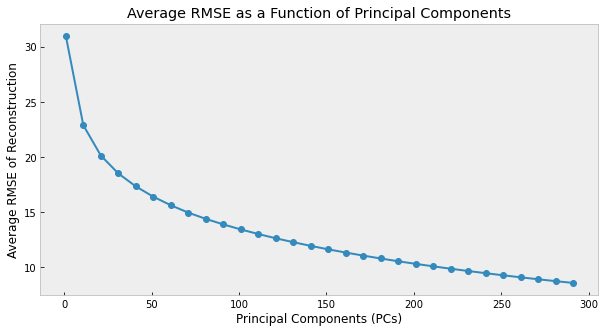

In [12]:
# average RMSE as a function of component count 

rmses = []

for i in range(1, 300, 10):
    pca = PCA(n_components=i)
    reduced = pca.fit_transform(X_train)
    reconstruct = pca.inverse_transform(reduced)

    rmse = np.sqrt(mean_squared_error(X_train, reconstruct))
    rmses.append(rmse)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 300, 10), rmses, marker='o')
plt.xlabel('Principal Components (PCs)')
plt.ylabel('Average RMSE of Reconstruction')
plt.title('Average RMSE as a Function of Principal Components')
plt.grid()
plt.show();

# Two Classifiers with Reduction

As with the original classifiers, I have decided to utilize a GridSearch, maintaining the same logic regarding hyperparameter selection and cross-validation schemes as problem one. PCA will be kept in mind however when deciding on hyperparameters; for instance, max_depth will be lowered to account for a lower subset of components compared to the initial amount of features.

PCA should help improve the efficiency and training time, as fewer components should allow for more streamlined computations from the models. Additionally, this may help curb overfitting as the model will not need to focus as hard on certain features that may not actually be tha important, given that PCA combines features into unique components that should store more generalizeable information. The linear nature of PCA should also allow for some interpretability if desired.

In [26]:
# build PCA-SVM pipeline

pca_svm_pipe = Pipeline([('scaler', MinMaxScaler()),
                         ('pca', PCA()),
                         ('svm', SVC(kernel='rbf'))])

pca_svm_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA()), ('svm', SVC())])

In [27]:
# build PCA-Random Forest pipeline

pca_rand_for_pipe = Pipeline([('scaler', MinMaxScaler()),
                              ('pca', PCA()),
                              ('rand_for', RandomForestClassifier(random_state=0))])
                           
pca_rand_for_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA()),
                ('rand_for', RandomForestClassifier(random_state=0))])

In [19]:
# cross-validate to find regularization parameter, C, for SVM, and n_components for PCA

param_grid = {
    'svm__C': [0.1, 1, 10],
    'pca__n_components': [80, 100, 120]
}

grid_search_pca_svm_pipe = GridSearchCV(pca_svm_pipe,
                                        param_grid=param_grid,
                                        cv=KFold(5, shuffle=True, random_state=0),
                                        scoring='accuracy')

grid_search_pca_svm_pipe.fit(X_train, t_train)

print(grid_search_pca_svm_pipe.best_params_)

{'pca__n_components': 120, 'svm__C': 10}


In [20]:
# train final model with desired hyperparameters, and calculate training time

pca_svm_model = Pipeline([('scaler', MinMaxScaler()),
                          ('pca', PCA(n_components=120)),
                          ('svm', SVC(kernel='rbf', C=10))])

t0 = time()
pca_svm_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
pca_svm_model

Training Time: 5.7 sec


Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=120)),
                ('svm', SVC(C=10))])

In [21]:
# cross-validate to find n_estimators and max_depth for Random Forest

param_grid = {
    'rand_for__n_estimators': [100, 200],
    'rand_for__max_depth': [10, 20, 30],
    'pca__n_components': [80, 100, 120]
}

grid_search_pca_rand_for_pipe = GridSearchCV(pca_rand_for_pipe,
                                             param_grid=param_grid,
                                             cv=KFold(5, shuffle=True, random_state=0),
                                             scoring='accuracy')

grid_search_pca_rand_for_pipe.fit(X_train, t_train)

print(grid_search_pca_rand_for_pipe.best_params_)

/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'pca__n_components': 100, 'rand_for__max_depth': 20, 'rand_for__n_estimators': 200}


In [23]:
# train final model with desired hyperparameters, and calculate training time

pca_rand_for_model = Pipeline([('scaler', MinMaxScaler()),
                               ('pca', PCA(n_components=100)),
                               ('rand_for', RandomForestClassifier(random_state=0,
                                                                   n_estimators=200,
                                                                   max_depth=20))])

t0 = time()
pca_rand_for_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
pca_rand_for_model

Training Time: 9.7 sec


Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=100)),
                ('rand_for',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=0))])

In [25]:
# save models as pickle files to use in testing

joblib.dump(pca_svm_model, 'models/pca_svm_model.pk1')
joblib.dump(pca_rand_for_model, 'models/pca_rand_for_model.pk1');

# Two Classifiers with Manifold Learning Algorithms

Similar to the previous classifiers, GridSearch will be used for hyperparameter tuning with a majority of the logic regarding decisions behind hyperparameter selection and cross-validation schemes remaining the same. 

I decided to proceed with Locally Linear Embedding (LLE) as my manifold learning algorithm. This was done for a few reasons. One main reason was due to the speed of LLE compared to other manifold learning algorithms; due to only requiring neighborhood graphs without computation about other distances, it should scale better to the size of the images and the amount of images in the training set. Additionally, LLE should capture the local trends that match when a ship is in an image; for instance, rotations may be able to be captured strong with LLE, and would be able to determine the underlying manifold structure effectively due to the ability to preserve those local relationships. 

I have decided to also only tune the n_components and n_neighbors hyperparameters for the LLE, as these should be the most impactful. Tuning n_neighbors with integers implies I will also be using a K-nearest neighbors approach, which I believe will be sufficient to capture the local relationships between items within the images. Tuning this parameter should ensure that the data maintains local relationships while excluding images that are not related to each other. Additionally, n_components is tuned in order to determine the amount of dimensions that bets captures the inherent structure of the manifold. 

In [5]:
# build LLE-SVM pipeline

lle_svm_pipe = Pipeline([('scale', MinMaxScaler()),
                         ('lle', LLE()),
                         ('svm', SVC(kernel='rbf'))])

lle_svm_pipe

Pipeline(steps=[('scale', MinMaxScaler()), ('lle', LocallyLinearEmbedding()),
                ('svm', SVC())])

In [6]:
# build LLE-Random Forest pipeline

lle_rand_for_pipe = Pipeline([('scale', MinMaxScaler()),
                              ('lle', LLE()),
                              ('rand_for', RandomForestClassifier(random_state=0))])

lle_rand_for_pipe

Pipeline(steps=[('scale', MinMaxScaler()), ('lle', LocallyLinearEmbedding()),
                ('rand_for', RandomForestClassifier(random_state=0))])

In [8]:
# cross-validate to find regularization parameter, C, for SVM, and n_components and n_neighbors for LLE

param_grid = {
    'svm__C': [0.1, 1, 10],
    'lle__n_components': [3, 5, 10, 15],
    'lle__n_neighbors': [5, 10, 20]
}

grid_search_lle_svm_pipe = GridSearchCV(lle_svm_pipe,
                                        param_grid=param_grid,
                                        cv=KFold(5, shuffle=True, random_state=0),
                                        scoring='accuracy')

grid_search_lle_svm_pipe.fit(X_train, t_train)

print(grid_search_lle_svm_pipe.best_params_)

{'lle__n_components': 15, 'lle__n_neighbors': 20, 'svm__C': 10}


In [5]:
# train final model with desired hyperparameters, and calculate training time

lle_svm_model = Pipeline([('scaler', MinMaxScaler()),
                          ('lle', LLE(n_components=15, n_neighbors=20)),
                          ('svm', SVC(kernel='rbf', C=10))])

t0 = time()
lle_svm_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
lle_svm_model

Training Time: 14 sec


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lle',
                 LocallyLinearEmbedding(n_components=15, n_neighbors=20)),
                ('svm', SVC(C=10))])

In [12]:
# cross-validate to find n_estimators and max_depth for Random Forest, and n_components and n_neighbors for LLE

param_grid = {
    'rand_for__n_estimators': [100, 200],
    'rand_for__max_depth': [10, 20],
    'lle__n_components': [10, 15],
    'lle__n_neighbors': [10, 20]
}

grid_search_lle_rand_for_pipe = GridSearchCV(lle_rand_for_pipe,
                                             param_grid=param_grid,
                                             cv=KFold(5, shuffle=True, random_state=0),
                                             scoring='accuracy')

grid_search_lle_rand_for_pipe.fit(X_train, t_train)

print(grid_search_lle_rand_for_pipe.best_params_)

{'lle__n_components': 15, 'lle__n_neighbors': 20, 'rand_for__max_depth': 20, 'rand_for__n_estimators': 200}


In [6]:
# train final model with desired hyperparameters, and calculate training time

lle_rand_for_model = Pipeline([('scaler', MinMaxScaler()),
                               ('lle', LLE(n_components=15, n_neighbors=20)),
                               ('rand_for', RandomForestClassifier(random_state=0,
                                                                   n_estimators=200,
                                                                   max_depth=20))])

t0 = time()
lle_rand_for_model.fit(X_train, t_train)
t1 = time()

print("Training Time: %.2g sec" % (t1 - t0))
lle_rand_for_model

Training Time: 16 sec


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lle',
                 LocallyLinearEmbedding(n_components=15, n_neighbors=20)),
                ('rand_for',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=0))])

In [14]:
# save models as pickle files to use in testing

joblib.dump(lle_svm_model, 'models/lle_svm_model.pk1')
joblib.dump(lle_rand_for_model, 'models/lle_rand_for_model.pk1');

In [10]:
# define function to plot components

from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

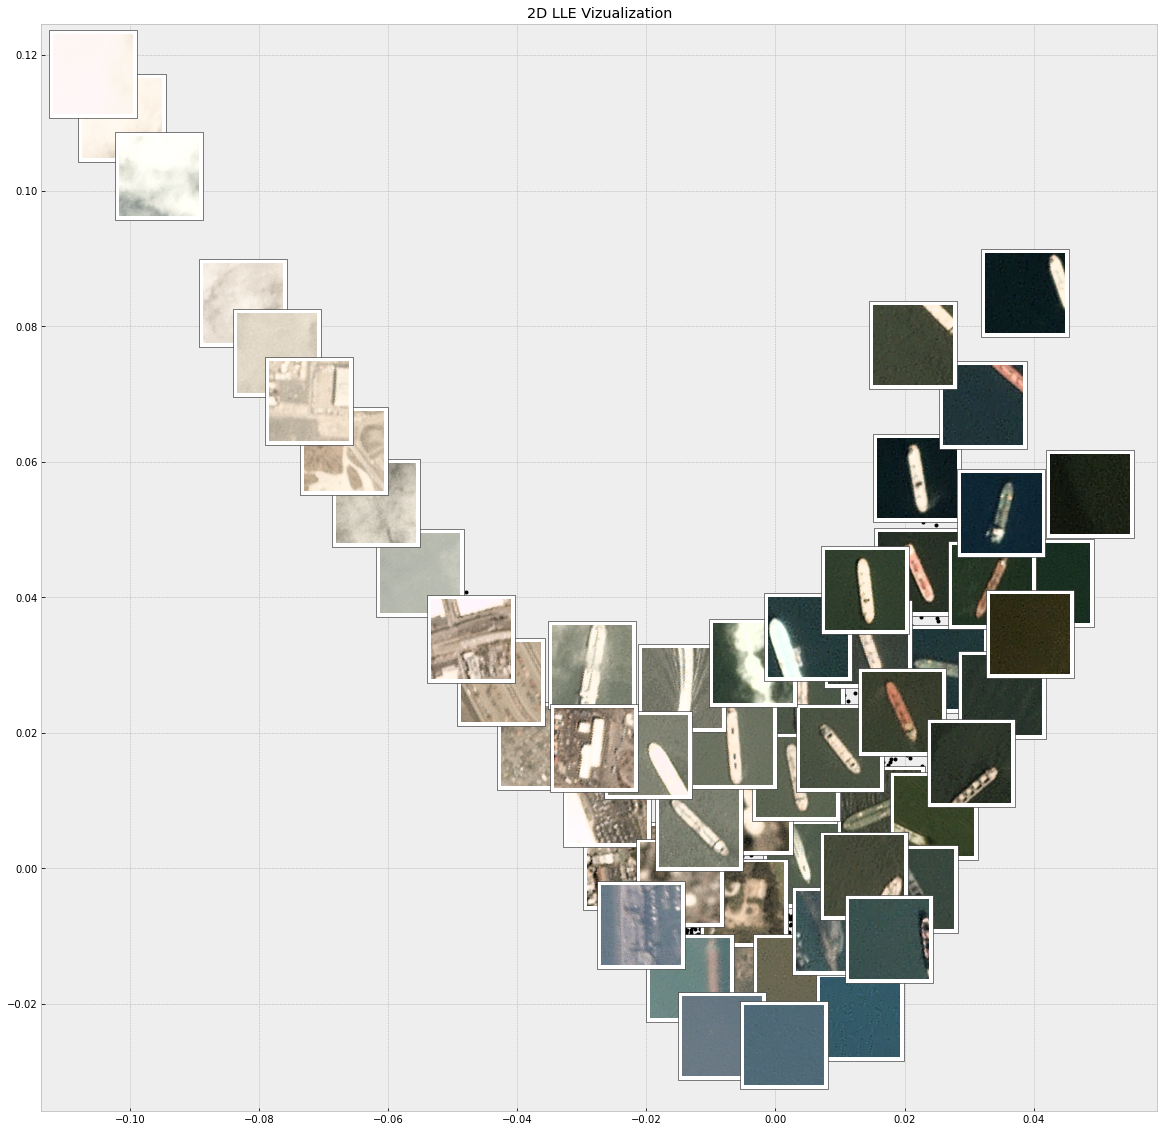

In [14]:
fig, ax = plt.subplots(figsize=(20,20))

lle = LLE(n_components=2, n_neighbors=20)

plot_components(X_train, lle, images=X_train.reshape(-1, 80, 80, 3),
                ax=ax)
plt.title('2D LLE Vizualization');

From this visualization, there are some clear trends among the 2D representation of our LLE. On the horizontal axis, it appears that images on the positive side are darker while images on the negative side are brighter. This also appears to mostly apply for the image average, rather than any specific point on the image; images with boats are slightly more towards the center than images with pure ocean pixels, probably due to the average being slightly brighter. This horizontal trend may also correlate with the two "prongs" from the center towards the vertical axis. Finding a solidified trend among the vertical data is slightly harder; again, among the two prongs the images get lighter/darker as the vertical value increases between the left/right. It may be that this also correlates with data getting less noisy as vertical value increases, as images with lots of pixel changes seem to be towards the bottom.